In [1]:
import torch
from torch_geometric.data import Data
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
import torch_geometric

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cuda')
print(DEVICE)

/home/tsou/.conda/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# get feature from csv
RAW_data = pd.read_csv('data/adult.csv')
CAT = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
NUM = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
LABEL = 'income'
# convert categorical data to ordinal data
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
data_pd = RAW_data.copy()
data_pd[CAT] = enc.fit_transform(RAW_data[CAT])
# data_pd = pd.get_dummies(RAW_data, columns=CAT, dtype=float)
# label to category
data_pd[LABEL] = data_pd[LABEL].astype('category').cat.codes

# realign data to num + cat
data_pd = data_pd[NUM + CAT + [LABEL]]

# caculate unique value of each categorical feature
cat_num = [len(data_pd[col].unique()) for col in CAT]

# normalize numerical data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_pd[NUM] = scaler.fit_transform(data_pd[NUM])

# convert data to tensor
x = torch.tensor(data_pd.drop(columns=[LABEL]).values, dtype=torch.float, device=DEVICE)  # [48842, 108]
y = torch.tensor(data_pd[LABEL].values, dtype=torch.long, device=DEVICE) # [48842]
print(x.shape, y.shape)
print(cat_num)
data_pd

torch.Size([48842, 14]) torch.Size([48842])
[9, 16, 7, 15, 6, 5, 2, 42]


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
0,-0.995129,0.351675,-1.197259,-0.144804,-0.217127,-0.034087,4.0,1.0,4.0,7.0,3.0,2.0,1.0,39.0,0
1,-0.046942,-0.945524,-0.419335,-0.144804,-0.217127,0.772930,4.0,11.0,2.0,5.0,0.0,4.0,1.0,39.0,0
2,-0.776316,1.394723,0.747550,-0.144804,-0.217127,-0.034087,2.0,7.0,2.0,11.0,0.0,4.0,1.0,39.0,1
3,0.390683,-0.277844,-0.030373,0.886874,-0.217127,-0.034087,4.0,15.0,2.0,7.0,0.0,2.0,1.0,39.0,1
4,-1.505691,-0.815954,-0.030373,-0.144804,-0.217127,-0.841104,0.0,15.0,4.0,0.0,3.0,4.0,0.0,39.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,-0.849254,0.640492,0.747550,-0.144804,-0.217127,-0.195490,4.0,7.0,2.0,13.0,5.0,4.0,0.0,39.0,0
48838,0.098933,-0.334178,-0.419335,-0.144804,-0.217127,-0.034087,4.0,11.0,2.0,7.0,0.0,4.0,1.0,39.0,1
48839,1.411808,-0.357510,-0.419335,-0.144804,-0.217127,-0.034087,4.0,11.0,6.0,1.0,4.0,4.0,0.0,39.0,0
48840,-1.213941,0.111984,-0.419335,-0.144804,-0.217127,-1.648120,4.0,11.0,4.0,1.0,3.0,4.0,1.0,39.0,0


In [3]:
# make column node embedding
columns = torch.tensor(range(len(RAW_data.columns.values)-1), dtype=torch.long, device=DEVICE) # [14]
print(columns)
columns_embedder = torch.nn.Embedding(len(RAW_data.columns.values)-1, 108, device=DEVICE) # [14, 108]
columns_emb = columns_embedder(columns) #[14, 108]
print(columns_emb.shape)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       device='cuda:0')
torch.Size([14, 108])


## model

In [8]:
class Net(torch.nn.Module):
    def __init__(self, NUM, CAT, LABEL, cat_num):
        super(Net, self).__init__()
        '''
        num_cols: number of numerical columns
        cat_cols: number of categorical columns
        label_cols: number of label columns
        cat_num: number of unique value of each categorical columns
        '''
        self.hidden_dim = 128
        
        # order: num -> cat -> label
        self.num_cols = len(NUM)
        self.cat_cols = len(CAT)
        self.label_cols = len(LABEL)
        
        # layers
        self.feature_importance_learner = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim * (self.num_cols + self.cat_cols), self.num_cols + self.cat_cols),
            # torch.nn.Sigmoid(),
            torch.nn.ReLU(),
        )
        
        # feature embedding layers
        # 如果要快的話，不可以用for迴圈，要大家一起乘上parameter，參考之前冠宇的作法
        self.num_weight = torch.nn.Parameter(torch.randn(self.num_cols, self.hidden_dim, 1, device=DEVICE), requires_grad=True) # [num_cols, hidden_dim]
        self.num_bias = torch.nn.Parameter(torch.randn(self.num_cols, self.hidden_dim, device=DEVICE), requires_grad=True) # [hidden_dim]
        
        # 要怎麼知道embedding要開多大
        self.cat_embedding = torch.nn.Embedding(sum(cat_num), self.hidden_dim, device=DEVICE, dtype=torch.float) # [sum(cat_num), hidden_dim]

        # graph convolution layers
        self.conv_1_input = torch_geometric.nn.GATConv((self.num_cols + self.cat_cols)*self.hidden_dim, self.hidden_dim)
        # self.conv_1_input = torch_geometric.nn.GCNConv(self.num_cols + self.cat_cols, self.hidden_dim)
        self.conv_2 = torch_geometric.nn.GCNConv(self.hidden_dim, self.hidden_dim)

        # prediction layer
        self.prediction = torch.nn.Linear((self.num_cols + self.cat_cols) * self.hidden_dim, 2)
        self.prediction_feature_importance = torch.nn.Linear((self.num_cols + self.cat_cols) * self.hidden_dim, 2)
        
        # normalization layer
        self.batch_norm1 = torch.nn.BatchNorm1d(self.hidden_dim * (self.num_cols + self.cat_cols),device=DEVICE)
        # self.batch_norm2 = torch.nn.BatchNorm1d(self.hidden_dim ,device=DEVICE)
        
    def forward(self, input_data, epoch = -1):
        '''
        shape of input_data: [batch_size, cols]
        cols = num_cols + cat_cols 
        '''
        # hyperparameters
        K = round(14*0.3) # top-k important features
        COLS_NUM = self.num_cols + self.cat_cols # number of columns
        
        input_data = input_data.to(DEVICE)
        
        # print('input_data.shape',input_data.shape)

        # feature embedding
        
        num_data = input_data[:,:self.num_cols].unsqueeze(-1).unsqueeze(-1) 
        num_weight = self.num_weight.transpose(1,2)
        num_bias = torch.stack([self.num_bias] * len(input_data))
        feature_embedding_num = torch.matmul(num_data, num_weight).transpose(2,3).squeeze(-1)
        feature_embedding_num = feature_embedding_num + num_bias # [batch_size, hidden_dim]
        feature_embedding_cat = self.cat_embedding(input_data[:,self.num_cols:].long()) # [batch_size, hidden_dim]
        feature_embedding = torch.cat((feature_embedding_num, feature_embedding_cat), dim=1) # [batch_size, cols, hidden_dim]
        # print('feature_embedding.shape',feature_embedding.shape)

        # learn feature importance and get top-k important features
        # print(feature_embedding.reshape(feature_embedding.shape[0],-1).shape)
        feature_importance = self.feature_importance_learner(feature_embedding.reshape(feature_embedding.shape[0],-1)) # [batch_size, cols]
        values, row_indices = torch.topk(feature_importance, k = K) # (value: [batch_size, k], indices: [batch_size, k])
        # row_indices = feature_importance_result[1] # [batch_size, k]
        # print('feature_importance shape',feature_importance.shape)
        # print(feature_importance[0])
        # print('row_indices',row_indices)
        
        
        importance_topk = torch.where(feature_importance >= values[:,[-1]], feature_importance, torch.zeros(feature_importance.shape,device=DEVICE)) # [batch_size, cols]
        
        # construct tensor of top-k importance table, where importance_topk[i][j] = 1 if j is in top-k important features of i
        # importance_topk = torch.zeros(input_data.size(0), COLS_NUM, device=DEVICE) # [batch_size, cols]
        # importance_topk.scatter_(1, row_indices, 1) # [batch_size, cols]
        # print('importance_topk',importance_topk)
        # print('importance_topk.shape',importance_topk.shape)
        # 現在的問題：沒有針對各個feature level graph做node的裁切，導致生成一張超大的圖
        # 上述問題已解決
        # 新問題：怎麼讓生成每張圖的速度變快，做到評型化
        # 解法，先不考慮評型化，每張圖用for迴圈做，
        # 新問題，現在每個colum只用一個數字表示，不夠大，應該要加一個feature embedding layer
        
        # copy importance_topk 
        importance_topk = torch.stack([importance_topk] * COLS_NUM, dim=0) # [cols, batch_size, cols]
        # print('importance_topk.shape',importance_topk.shape)
        
        
        # for each column, drop columns and row thar are not important in target column
        # which means, importance_topk[target_col].T[target_col]==0 should be dropped
        processed_data = [] 
        for target_col in range(COLS_NUM):
            
            importance_topk_current = importance_topk[target_col] # [batch_size, cols]
            indices = importance_topk_current.T[target_col].nonzero().T[0] # selected samples' indices
            importance_topk_current = importance_topk_current[importance_topk_current.T[target_col]>0]# [????, cols]
            # print('importance_topk.shape',importance_topk.shape)  
            # print('importance_topk',importance_topk)  
            # print('indices', len(indices), indices)
        
        
            # for target column, set its importance to 0. so that it will not be fully connected graph
            # copy target column
            tmp = torch.clone(importance_topk_current[:,target_col]) # [????], save for future weighted sum
            importance_topk_current[:,target_col] = 0 # [batch_size, cols]
            
            # multiply to get weighted adj
            weighted_adj = torch.matmul(importance_topk_current, importance_topk_current.T) # [batch_size, cols] * [cols, batch_size] = [batch_size, batch_size]
            # prune the diagonal
            weighted_adj = weighted_adj - torch.diag(weighted_adj.diagonal())
            # print('weighted_adj',weighted_adj)
            # print('weighted_adj.shape',weighted_adj.shape)
            
            # construct graph edge
            edge_index = weighted_adj.nonzero().T  # [2, num_edges]
            edge_wight = weighted_adj[edge_index[0], edge_index[1]] # [num_edges]
            
            # construct node feature
            # features = input_data[indices] 
            importance_topk_current[:,target_col] = tmp # [????, cols]
            # print(feature_embedding[indices].shape)
            # print(importance_topk_current.unsqueeze(2).shape)
            try:
                features = (feature_embedding[indices] * importance_topk_current.unsqueeze(2)).reshape(len(indices),-1) # [????, cols*hidden_dim]
                # features = (feature_embedding[indices] ).reshape(len(indices),-1) # [????, cols*hidden_dim]
            except:
                # if there is no nodes in the graph, continue
                target_col_data = torch.zeros(feature_embedding.size(0), self.hidden_dim, device=DEVICE) # [batch_size, hidden_dim]
                processed_data.append(target_col_data)
                continue

            
            # construct graph 
            data = Data(x=features, edge_index=edge_index, edge_weight=edge_wight, indices=indices) 
            
            if epoch % 1000 == 0 and epoch != -1:
                try:
                    print('in feature graph',target_col, 'node num', len(indices), 'edge num', len(edge_index[0]), 'ratio', round(len(edge_index[0])/(len(indices)**2),3))
                except:
                    print('in feature graph',target_col, 'node num', len(indices), 'edge num', len(edge_index[0]), 'ratio', 'NA')
                
                
            # apply GCN
            # x = self.batch_norm1(data.x)
            x = torch.layer_norm(data.x, data.x.shape) # [num_nodes, hidden_dim]
            x = self.conv_1_input(x, data.edge_index, data.edge_weight)  # [num_nodes, hidden_dim]
            
            # x = torch.layer_norm(x, x.shape) # [num_nodes, hidden_dim]
            # x = self.batch_norm2(x)
            x = torch.relu(x)
            

            target_col_data = torch.zeros(feature_embedding.size(0), self.hidden_dim, device=DEVICE) # [batch_size, hidden_dim]
            target_col_data.index_add_(0, indices , x) # [batch_size, hidden_dim]
            processed_data.append(target_col_data)

        
        processed_data = torch.stack(processed_data, dim=0) # [cols, batch_size, hidden_dim]
        processed_data = torch.permute(processed_data, (1,0,2)) # [batch_size, cols, hidden_dim]
        processed_data = processed_data.reshape(processed_data.shape[0],-1) # [batch_size, cols*hidden_dim]
            
        # print('importance_topk[0]',importance_topk[0])
        # print('importance_topk[0].shape',importance_topk[0].shape)

        # print('processed_data',processed_data)
        # print('processed_data.shape',processed_data.shape)  

        # make prediction
        output = self.prediction(processed_data) # [num_nodes, label_cols]
        # print(output.shape) 
        
        features_ = (feature_embedding * feature_importance.unsqueeze(2)).reshape(len(input_data),-1) # [????, cols*hidden_dim]
        output_feature_importance = self.prediction_feature_importance(features_) # [num_nodes, label_cols]
        
        return output, output_feature_importance

### 問題： 訓練太不穩定了，是不是因為layernorm造成的

In [10]:
the_model = Net(NUM, CAT, [LABEL], cat_num).to(DEVICE)
optimizer = torch.optim.SGD(the_model.parameters(), lr=0.01)

# output = the_model(x[:1000], epoch=200)
# loss = torch.nn.functional.cross_entropy(output, y[:1000])
# loss.backward()
# # print(the_model.num_weight.grad)

# # print(the_model.feature_importance_learners_bias.grad)
# # print(the_model.feature_importance_learners.grad.shape)
# # print(the_model.feature_importance_learners.grad)
# print(sum(the_model.feature_importance_learners.grad))

# # print(the_model.feature_importance_learners.grad[0].shape)
# # # print(the_model.feature_importance_learners_mask.grad)

# optimizer.step()
for i in range(15):
    optimizer.zero_grad()
    output = the_model(x[:1000], epoch=200)
    loss1 = torch.nn.functional.cross_entropy(output[0], y[:1000])
    print(loss1)
    loss2 = torch.nn.functional.cross_entropy(output[1], y[:1000])
    print(loss2)
    loss = loss1 + loss2
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(the_model.parameters(), 1)
    print((sum(the_model.feature_importance_learner[0].weight)))
    print((sum(the_model.feature_importance_learner[0].weight.grad)))
    # print(len(the_model.feature_importance_learner[0].weight.grad))
    
    optimizer.step()
    print('-----------------------------------------')


tensor(0.7611, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6608, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([-0.0873,  0.0263,  0.1069,  ...,  0.0487, -0.0168, -0.0932],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([ 0.2259,  0.1133,  0.1657,  ...,  0.1217,  0.0257, -0.0367],
       device='cuda:0')
-----------------------------------------
tensor(0.7445, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4474, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([-0.0896,  0.0252,  0.1053,  ...,  0.0474, -0.0171, -0.0928],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([-0.0715, -0.0590, -0.1027,  ..., -0.0694, -0.0100,  0.0022],
       device='cuda:0')
-----------------------------------------
tensor(0.5165, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([-0.0889,  0.0258,  0.1063,  ...,  0.0481, -0.0170, -0.0928],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([-0.1019, -0

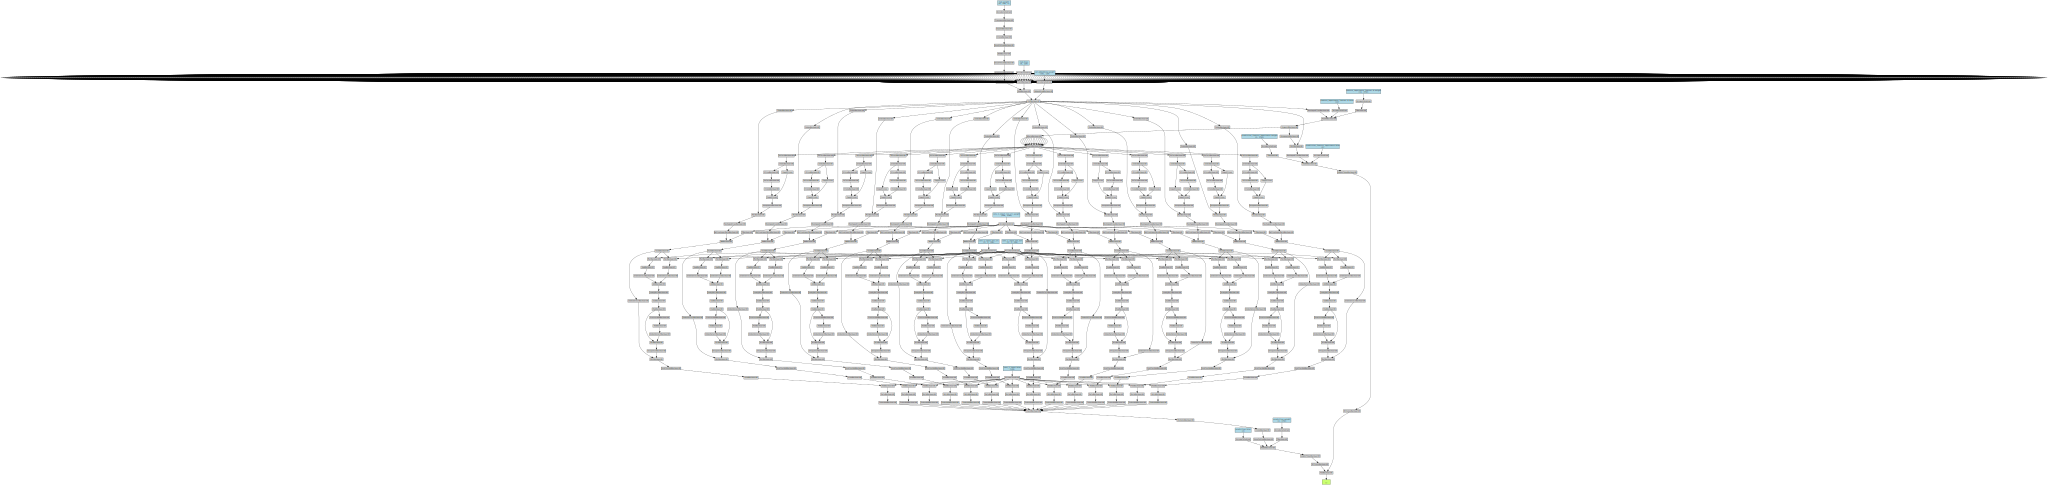

In [6]:
import torchviz
torchviz.make_dot(loss, params=dict(the_model.named_parameters()))

In [7]:
the_model = Net(NUM, CAT, [LABEL], cat_num).to(DEVICE)
optimizer = torch.optim.SGD(the_model.parameters(), lr=0.001)

output = the_model(x[:1000], epoch=100)

loss = output.sum()
loss.backward()
print(the_model.feature_importance_learner[0].weight.grad)
# print(the_model.num_weight.grad)

optimizer.step()

AttributeError: 'tuple' object has no attribute 'sum'

In [ ]:
#
def train(model, optimizer, x, y):
    epoch = 5000
    
    for i in range(epoch):
        model.train()
        optimizer.zero_grad()
        out = model(x, i+1)
        loss = torch.nn.functional.cross_entropy(out[0], y)
        loss = loss + torch.nn.functional.cross_entropy(out[1], y)
        loss.backward()
        optimizer.step()
        # calculate accuracy
        pred = out[0].argmax(dim=1)
        correct = pred.eq(y).sum().item()
        acc = correct / len(y)
        # caculate AUC
        from sklearn.metrics import roc_auc_score
        auc = roc_auc_score(y.cpu().numpy(), pred.cpu().numpy())
        print('epoch',i,'loss',loss.item(),'acc',acc,'AUC',auc, 'pred', sum(pred))
    return 
the_model = Net(NUM, CAT, [LABEL], cat_num).to(DEVICE)
train(the_model, torch.optim.SGD(the_model.parameters(), lr=0.001), x[:1000], y[:1000])

epoch 1123 loss 0.7224371433258057 acc 0.799 AUC 0.6240131578947369 pred tensor(99, device='cuda:0')
epoch 1124 loss 0.7233364582061768 acc 0.799 AUC 0.6240131578947369 pred tensor(99, device='cuda:0')
epoch 1125 loss 0.7221413850784302 acc 0.8 AUC 0.6260964912280702 pred tensor(100, device='cuda:0')
epoch 1126 loss 0.7230410575866699 acc 0.8 AUC 0.6260964912280702 pred tensor(100, device='cuda:0')
epoch 1127 loss 0.7229706048965454 acc 0.8 AUC 0.6260964912280702 pred tensor(100, device='cuda:0')
epoch 1128 loss 0.7214260101318359 acc 0.8 AUC 0.6260964912280702 pred tensor(100, device='cuda:0')
epoch 1129 loss 0.7223295569419861 acc 0.8 AUC 0.6260964912280702 pred tensor(100, device='cuda:0')
epoch 1130 loss 0.7211469411849976 acc 0.8 AUC 0.6260964912280702 pred tensor(100, device='cuda:0')
epoch 1131 loss 0.721801221370697 acc 0.8 AUC 0.6260964912280702 pred tensor(100, device='cuda:0')
epoch 1132 loss 0.7203724384307861 acc 0.801 AUC 0.6281798245614035 pred tensor(101, device='cuda:0

KeyboardInterrupt: 

# playground


## matrix mul to get ADJ

In [ ]:
A = torch.tensor([[0,1,1],
                  [0,1,1],
                  [0,1,1],
                  [1,1,0]], dtype=torch.float)
print(A.shape,A.T.shape)

In [ ]:
ADJ = torch.matmul(A, A.T)
print(ADJ)
# convert to edge_index
edge_index = torch.tensor([[i, j] for i in range(ADJ.shape[0]) for j in range(ADJ.shape[1]) if (ADJ[i,j] >= 1) and (i!=j)], dtype=torch.long).t()
print(edge_index)
# make graph with weighted adjacency matrix
data = Data(edge_index=edge_index)
data

In [ ]:
def visualize(data):
    import networkx as nx
    import matplotlib.pyplot as plt
    from torch_geometric.utils import to_networkx
    import torch_geometric.datasets as datasets

    G = to_networkx(data)

    # 绘制 NetworkX 图
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # 定义节点位置
    nx.draw(G, pos, with_labels=True, node_size=200, node_color='skyblue', font_weight='bold', font_size=8, edge_color='gray')
    plt.title('Graph Visualization')
    plt.show()
visualize(data)

## model 

In [ ]:
# backup of old code

class Net(torch.nn.Module):
    def __init__(self, NUM, CAT, LABEL):
        super(Net, self).__init__()
        '''
        num_cols: number of numerical columns
        cat_cols: number of categorical columns
        label_cols: number of label columns
        '''
        self.hidden_dim = 128
        
        # order: num -> cat -> label
        self.num_cols = len(NUM)
        self.cat_cols = len(CAT)
        self.label_cols = len(LABEL)
        
        # layers
        self.feature_importance_learner = torch.nn.Linear(self.num_cols + self.cat_cols, self.num_cols + self.cat_cols)
        self.conv_1_input = torch_geometric.nn.GCNConv(self.num_cols + self.cat_cols, self.hidden_dim)
        self.conv_2 = torch_geometric.nn.GCNConv(self.hidden_dim, self.hidden_dim)

        
    def forward(self, input_data):
        '''
        shape of input_data: [batch_size, cols]
        cols = num_cols + cat_cols 
        '''
        # print(input_data)
        
        # learn feature importance and get top-k important features
        feature_importance = self.feature_importance_learner(input_data) # [batch_size, cols]
        values, row_indices = torch.topk(feature_importance, k=3) # (value: [batch_size, k], indices: [batch_size, k])
        # row_indices = feature_importance_result[1] # [batch_size, k]
        # print(feature_importance.shape)
        # print(row_indices)
        
        
        importance_topk = torch.where(feature_importance >= values[:,[-1]], feature_importance, torch.zeros(feature_importance.shape,device=DEVICE)) # [batch_size, cols]
            
        # # construct tensor of top-k importance table, where importance_topk[i][j] = 1 if j is in top-k important features of i
        # importance_topk = torch.zeros(input_data.size(0), self.num_cols + self.cat_cols, device=DEVICE) # [batch_size, cols]
        # importance_topk.scatter_(1, row_indices, 1) # [batch_size, cols]
        # # print(importance_topk)
        # # print(importance_topk.shape)
        
        # multiply to get weighted adj
        weighted_adj = torch.matmul(importance_topk, importance_topk.T) # [batch_size, cols] * [cols, batch_size] = [batch_size, batch_size]
        # print(weighted_adj)
        # print(weighted_adj.shape)
        
        # construct graph
        edge_index = weighted_adj.nonzero().T  # [2, num_edges]
        edge_wight = weighted_adj[edge_index[0], edge_index[1]] # [num_edges]
        data = Data(x=input_data, edge_index=edge_index, edge_weight=edge_wight) 
        # print(edge_index, edge_index.shape)
        # print(edge_wight, edge_wight.shape)
        
        # apply GCN
        # print(data.x.shape)  # [num_nodes, num_cols]
        x = self.conv_1_input(data.x, data.edge_index, data.edge_weight)  # [num_nodes, hidden_dim]
        # print(x.shape)
        x = self.conv_2(x, data.edge_index, data.edge_weight) # [num_nodes, hidden_dim]
        # print(x.shape)
        
        return x

In [ ]:
the_model = Net(NUM, CAT, LABEL).to(DEVICE)
the_model(x[:10])

### v2

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, NUM, CAT, LABEL):
        super(Net, self).__init__()
        '''
        num_cols: number of numerical columns
        cat_cols: number of categorical columns
        label_cols: number of label columns
        '''
        self.hidden_dim = 128
        
        # order: num -> cat -> label
        self.num_cols = len(NUM)
        self.cat_cols = len(CAT)
        self.label_cols = len(LABEL)
        
        # layers
        self.feature_importance_learner = torch.nn.Linear(self.num_cols + self.cat_cols, self.num_cols + self.cat_cols)
        self.conv_1_input = torch_geometric.nn.GCNConv(self.num_cols + self.cat_cols, self.hidden_dim)
        self.conv_2 = torch_geometric.nn.GCNConv(self.hidden_dim, self.hidden_dim)

        # prediction layer
        self.prediction = torch.nn.Linear(self.hidden_dim, self.label_cols)
        
        
    def forward(self, input_data):
        '''
        shape of input_data: [batch_size, cols]
        cols = num_cols + cat_cols 
        '''
        print('input_data',input_data)
        
        # learn feature importance and get top-k important features
        feature_importance = self.feature_importance_learner(input_data) # [batch_size, cols]
        feature_importance_result = torch.topk(feature_importance, k=3) # (value: [batch_size, k], indices: [batch_size, k])
        row_indices = feature_importance_result[1] # [batch_size, k]
        print('feature_importance shape',feature_importance.shape)
        print('row_indices',row_indices)
        
        # construct tensor of top-k importance table, where importance_topk[i][j] = 1 if j is in top-k important features of i
        importance_topk = torch.zeros(input_data.size(0), self.num_cols + self.cat_cols, device=DEVICE) # [batch_size, cols]
        importance_topk.scatter_(1, row_indices, 1) # [batch_size, cols]
        print('importance_topk',importance_topk)
        print('importance_topk.shape',importance_topk.shape)
        # 現在的問題：沒有針對各個feature level graph做node的裁切，導致生成一張超大的圖
        # 上述問題已解決
        # 新問題：怎麼讓生成每張圖的速度變快，做到評型化
        
        
        # drop columns and row thar are not important in target column
        # which means, importance_topk.T[target_col]==0 should be dropped
        target_col = 0
        indices = importance_topk.T[target_col].nonzero().T # selected samples' indices
        importance_topk = importance_topk[importance_topk.T[target_col]==1]# [????, cols]
        print('importance_topk.shape',importance_topk.shape)  
        print('importance_topk',importance_topk)  
        print('indices', len(indices[0]), indices)
        
        
        # for target column, set its importance to 0. so that it will not be all connected
        importance_topk[:,target_col] = 0 # [batch_size, cols]
        
        # multiply to get weighted adj
        weighted_adj = torch.matmul(importance_topk, importance_topk.T) # [batch_size, cols] * [cols, batch_size] = [batch_size, batch_size]
        # prune the diagonal
        weighted_adj = weighted_adj - torch.diag(weighted_adj.diagonal())
        print('weighted_adj',weighted_adj)
        print('weighted_adj.shape',weighted_adj.shape)
        
        # construct graph
        edge_index = weighted_adj.nonzero().T  # [2, num_edges]
        edge_wight = weighted_adj[edge_index[0], edge_index[1]] # [num_edges]
        data = Data(x=input_data, edge_index=edge_index, edge_weight=edge_wight) 
        print('edge_index', edge_index, edge_index.shape)
        print('edge_wight', edge_wight, edge_wight.shape)
        
        # apply GCN
        print(data.x.shape)  # [num_nodes, num_cols]
        x = self.conv_1_input(data.x, data.edge_index, data.edge_weight)  # [num_nodes, hidden_dim]
        print(x.shape)
        x = self.conv_2(x, data.edge_index, data.edge_weight) # [num_nodes, hidden_dim]
        print(x.shape)

        # make prediction
        x = self.prediction(x) # [num_nodes, label_cols]
        print(x.shape) 
        
        return x

## tensor 

In [ ]:
B = torch.tensor([
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])
print(B.shape)
print(torch.stack([B]*3, dim=0).shape)

In [ ]:
A = torch.tensor([[
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],
        [[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]]])
print(A.shape)
print(A[0][A[0].T[0]==1])
# get indince
print(A[0].T[0].nonzero().T)


print(A[1][A[1].T[1]==1])
# get indince
print(A[1].T[1].nonzero().T)

In [ ]:
def get_vaild_samples(A, a):
    target_col = A.index(a)
    return a[a.T[target_col]==1]

In [ ]:
for i, a in enumerate(A):
    print(get_vaild_samples(A,a))

In [ ]:
A.apply_(lambda x: get_vaild_samples(A,x))

In [ ]:
A[0][A[0].T[0]==1]  

In [ ]:
x = torch.zeros(5, 3)
print(x)
t = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)
print(t)
index = torch.tensor([0, 4, 2])
print(index)
print(x.index_add_(0, index, t))
print(x.index_add_(0, index, t, alpha=-1))


## check gradient

In [ ]:
import torch
from torch.autograd import Variable

# 定义一个简单的模型
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = torch.nn.Linear(2, 1)

    def forward(self, x):
        return self.linear(x)

# 初始化模型和优化器
model = SimpleModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 定义输入
input_data = Variable(torch.randn(5, 2), requires_grad=True)

# 前向传播
output = model(input_data)

# 反向传播
loss = output.sum()
loss.backward()

# 定义一个用于查看梯度的函数
def print_grad(grad):
    print('grad is',grad)

# 注册hook来查看梯度
model.linear.weight.register_hook(print_grad)
model.linear.bias.register_hook(print_grad)

# 进行优化器的一步更新
optimizer.step()

In [ ]:
model.linear.weight.grad

In [ ]:
v = torch.tensor([0., 0., 0.], requires_grad=True)
h = v.register_hook(lambda grad: grad * 2)  # double the gradient
v.backward(torch.tensor([1., 2., 3.]))
v.grad

## feature importance tensor

In [ ]:
input_data = Variable(torch.randn(10, 14), requires_grad=True)
learner = torch.nn.Linear(14, 14)
feature_importance = learner(input_data) # [batch_size, cols]
feature_importance_result = torch.topk(feature_importance, k = 3) # (value: [batch_size, k], indices: [batch_size, k])
row_indices = feature_importance_result[1] # [batch_size, k]
print('feature_importance shape',feature_importance.shape)
print('row_indices',row_indices)

# construct tensor of top-k importance table, where importance_topk[i][j] = 1 if j is in top-k important features of i
importance_topk = torch.zeros(input_data.size(0), 14) # [batch_size, cols]
importance_topk.scatter_(1, row_indices, 1) # [batch_size, cols]
print('importance_topk',importance_topk)
print('importance_topk.shape',importance_topk.shape)


In [ ]:
input_data = Variable(torch.randn(10, 14), requires_grad=True)
learner = torch.nn.Linear(14, 14)
feature_importance = learner(input_data) # [batch_size, cols]
values, indices = torch.topk(feature_importance, k = 3) # (value: [batch_size, k], indices: [batch_size, k])
print(values, indices)
feature_importance = torch.where(feature_importance >= values[:,[-1]], feature_importance, torch.zeros(feature_importance.shape))
print(feature_importance)
 # multiply to get weighted adj
weighted_adj = torch.matmul(feature_importance, feature_importance.T) # [batch_size, cols] * [cols, batch_size] = [batch_size, batch_size]
print(weighted_adj)
print(weighted_adj.shape)

# # construct graph
edge_index = weighted_adj.nonzero().T  # [2, num_edges]
edge_wight = weighted_adj[edge_index[0], edge_index[1]] # [num_edges]


## end